In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from config import ExperimentType
from precomputation import RunPair
from correlations import conditional_correlation

In [ ]:
def overall_correlation(pair_corrs, weighted=True):
    def condition(hp_pair):
        return ExperimentType.BATCH_NORM not in hp_pair[0][1] and ExperimentType.BATCH_NORM not in hp_pair[1][1]

    return conditional_correlation(pair_corrs, condition, weighted=weighted)

In [21]:
types = ["margin", "exponential_margin", "normalized_exponential_margin", "shifted_margin", "pac_bayes", 
         "vc_dim", "norms", "optimisation"]
steps = [0.001, 0.01, 0.1, 1] + list(range(5, 301, 5))
seed_corrs = []

for seed in [0, 17, 43]:
    corrs = {}
    corrs["test_acc"] = []
    
    for a in types:
        with open("./new_data.nosync/pre-comp/{}-best-{}.pickle".format(a, seed), "rb") as f:
            pair_corrs = pickle.load(f)

        corrs[a] = {}
        overall_corrs = overall_correlation(pair_corrs)

        for s in steps:
            max_corr = 0
            for m, x in overall_corrs[s].items():
                abs_weights = sum([abs(i) for i in x])
                c = 0 if abs_weights == 0 else sum(x)/abs_weights

                if m == "accuracy/test":
                    corrs["test_acc"].append(c)
                else:
                    meas_corrs = corrs[a].get(m, [])
                    meas_corrs.append(c)
                    corrs[a][m] = meas_corrs
                    
                    
    seed_corrs.append(corrs)

In [33]:
for l in seed_corrs:
    for meas in ["sotl-ema", "sotl-2", "sotl-3", "sotl-5"]:
        l["optimisation"][meas] = [0, 0, 0] + l["optimisation"][meas]

64
64
64
64
64
64
64
64
64
64
64
64


In [35]:
av_corrs = {}

for a in types:
    av_corrs[a] = {}
    
    for meas in seed_corrs[0][a]:
        av_corrs[a][meas] = []
        for i in range(64):
            av_corrs[a][meas].append(np.mean([seed_corrs[j][a][meas][i] for j in range(3)]))
            
av_corrs["test_acc"] = []
for i in range(64):
    av_corrs["test_acc"].append(np.mean([seed_corrs[j]["test_acc"][i] for j in range(3)]))

In [74]:
max_corrs = {}

for a in ["pac_bayes", "vc_dim", "norms", "optimisation"]:
    max_corrs[a] = []
    for i in range(64):
        max_corrs[a].append(max([abs(av_corrs[a][m][i]) for m in av_corrs[a]]))

max_corrs["margin"] = []
for i in range(64):
    max_corrs["margin"].append(max([max(abs(av_corrs[b][m][i]) for m in av_corrs[b]) for b in ["margin", "exponential_margin", "normalized_exponential_margin", "shifted_margin"]]))
    
max_corrs["test_acc"] = av_corrs["test_acc"]
max_corrs["test_acc"][2] = 0.01

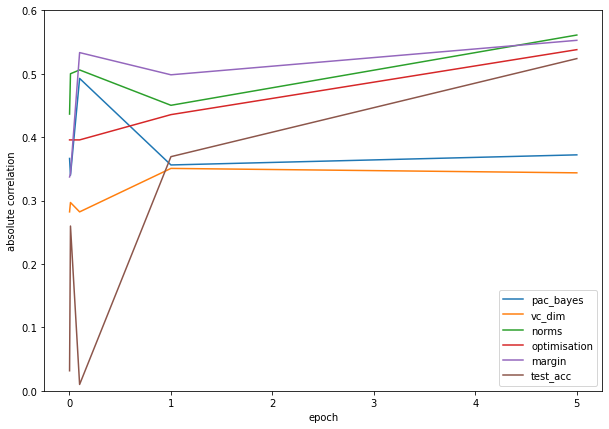

In [86]:
plt.figure(figsize=(10, 7))

for x in max_corrs:
    plt.plot(steps[:5], max_corrs[x][:5], label=x)

plt.ylim([0, 0.6])
plt.xlabel("epoch")
plt.ylabel("absolute correlation")
plt.legend()
plt.show()